In [200]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Dropout
from keras.metrics import RootMeanSquaredError
%matplotlib inline

### Loading Preprocessed Dataset

In [3]:
df = pd.read_csv('tmp/mse_raw.csv', parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [4]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


### setting RNN ALK dataset for training, validation and test

In [6]:
alk_df = df[df.stock_id == 'ALK']

In [8]:
alk_df.columns

Index(['stock_id', 'date', 'open', 'high', 'low', 'average', 'close', 'volume',
       'quantity', 'change %', 'volume total', 'start_date'],
      dtype='object')

### split dataset

In [13]:
#Create a new dataframe with only closing price column
close_price = alk_df['close']

#Convert the dataframe into numpy array
close_price = close_price.values

In [18]:
close_price.shape

(8630,)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [23]:
scaled_df = scaler.fit_transform(close_price.reshape(len(close_price), 1))

In [24]:
scaled_df

array([[0.04175824],
       [0.04175824],
       [0.04175824],
       ...,
       [0.86373626],
       [0.86373626],
       [0.85714286]])

### univariate sequence

In [124]:
# split a univariate sequence into samples with one day prediciton
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [30]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(scaled_df, n_steps)
# summarize the data
for i in range(3):
    print(X[i], y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04029304]


### Vanilla LSTM, one day prediciton

In [83]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-1),], X[int(len(X)-1):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-1),], y[int(len(X)-1):,]

In [84]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8567, 3, 1), (59, 3, 1), (1, 3, 1), (8567, 1), (59, 1), (1, 1))

In [85]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [103]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
rmse = RootMeanSquaredError()

In [111]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [112]:
my_callback1 = ModelCheckpoint('vanila_best.pt', verbose=1, save_best_only=True, mode='min', monitor='val_loss')
my_callback2 = EarlyStopping(patience=10)

my_callbacks = [my_callback1, my_callback2]

In [113]:
# fit model
model.fit(X_train, y_train, epochs=50, callbacks=my_callbacks, validation_data=[X_valid, y_valid])

Train on 8567 samples, validate on 59 samples
Epoch 1/50
8567/8567 [==============================] - 2s 259us/step - loss: 0.0131 - val_loss: 1.6283e-04

Epoch 00001: val_loss improved from inf to 0.00016, saving model to vanila_best.pt
Epoch 2/50
8567/8567 [==============================] - 2s 185us/step - loss: 7.8980e-05 - val_loss: 6.0614e-05

Epoch 00002: val_loss improved from 0.00016 to 0.00006, saving model to vanila_best.pt
Epoch 3/50
8567/8567 [==============================] - 2s 203us/step - loss: 7.7059e-05 - val_loss: 6.0599e-05

Epoch 00003: val_loss improved from 0.00006 to 0.00006, saving model to vanila_best.pt
Epoch 4/50
8567/8567 [==============================] - 2s 193us/step - loss: 7.7404e-05 - val_loss: 6.5257e-05

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/50
8567/8567 [==============================] - 2s 188us/step - loss: 7.5061e-05 - val_loss: 7.9386e-05

Epoch 00005: val_loss did not improve from 0.00006
Epoch 6/50
8567/8567 [============

In [114]:
yhat = model.predict(X_test, verbose=0)

In [115]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)

In [118]:
np.sqrt(mean_squared_error(y_actual, y_pred))

36.423828125

### Stacked LSTM, one day prediciton

In [119]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X, y, epochs=200, verbose=1)

In [120]:
# fit model
model.fit(X_train, y_train, epochs=50, callbacks=my_callbacks, validation_data=[X_valid, y_valid])

Train on 8567 samples, validate on 59 samples
Epoch 1/50
8567/8567 [==============================] - 4s 476us/step - loss: 0.0117 - val_loss: 3.8548e-04

Epoch 00001: val_loss did not improve from 0.00006
Epoch 2/50
8567/8567 [==============================] - 3s 311us/step - loss: 1.0804e-04 - val_loss: 9.7736e-05

Epoch 00002: val_loss did not improve from 0.00006
Epoch 3/50
8567/8567 [==============================] - 3s 328us/step - loss: 1.0243e-04 - val_loss: 8.1860e-05

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/50
8567/8567 [==============================] - 3s 321us/step - loss: 9.9187e-05 - val_loss: 8.5131e-05

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/50
8567/8567 [==============================] - 3s 314us/step - loss: 1.0051e-04 - val_loss: 4.3703e-04

Epoch 00005: val_loss did not improve from 0.00006
Epoch 6/50
8567/8567 [==============================] - 3s 308us/step - loss: 1.0516e-04 - val_loss: 6.8270e-05

Epoch 00006: val_loss did

8567/8567 [==============================] - 3s 310us/step - loss: 6.0044e-05 - val_loss: 6.5507e-05

Epoch 00050: val_loss did not improve from 0.00005


In [121]:
yhat = model.predict(X_test, verbose=0)

In [123]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)
np.sqrt(mean_squared_error(y_actual, y_pred))

139.701171875

### univariate sequence many to many

In [125]:
# function that segments the data
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [170]:
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
n_features = 1

# split the data into samples
X, y = split_sequence(scaled_df, n_steps_in, n_steps_out)

# print the first 3 samples for trainX and trainY
for i in range(3):
    print(X[i], "\n Y: "  ,y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04029304]
 [0.04029304]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]] 
 Y:  [[0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]]
[[0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04029304]
 [0.04029304]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784

In [171]:
X.shape, y.shape

((8571, 30, 1), (8571, 30, 1))

In [172]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-30),], X[int(len(X)-30):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-30),], y[int(len(X)-30):,]

In [173]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8511, 30, 1),
 (30, 30, 1),
 (30, 30, 1),
 (8511, 30, 1),
 (30, 30, 1),
 (30, 30, 1))

In [174]:
# There are 30 (n_steps_out) predictions for each data point. 
# Thus, we need to take the predicitons on each 'n_steps_out' step 
X_valid, y_valid = X_test[::n_steps_out], y_test[::n_steps_out]
X_test, y_test = X_test[::n_steps_out], y_test[::n_steps_out]

In [175]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8511, 30, 1), (1, 30, 1), (1, 30, 1), (8511, 30, 1), (1, 30, 1), (1, 30, 1))

In [201]:
from keras.layers import RepeatVector

# define model

model_many_to_many = Sequential()
model_many_to_many.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model_many_to_many.add(RepeatVector(n_steps_out))
model_many_to_many.add(Dropout(0.2))
model_many_to_many.add(LSTM(100, activation='relu', return_sequences=True))
model_many_to_many.add(Dropout(0.2))
model_many_to_many.add(Dense(1))
model_many_to_many.compile(optimizer='adam', loss='mae')
print(model_many_to_many.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 30, 100)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
dense_15 (Dense)             (None, 30, 1)             101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_______________________________________________

In [202]:
model_many_to_many.fit(X_train, y_train,
                       epochs=50,
                       callbacks=my_callbacks,
                       verbose=1,
                       validation_data=[X_valid, y_valid])

Train on 8511 samples, validate on 1 samples
Epoch 1/50
8511/8511 [==============================] - 33s 4ms/step - loss: 0.0487 - val_loss: 0.0201

Epoch 00001: val_loss did not improve from 0.00005
Epoch 2/50
8511/8511 [==============================] - 31s 4ms/step - loss: 0.0264 - val_loss: 0.0252

Epoch 00002: val_loss did not improve from 0.00005
Epoch 3/50
8511/8511 [==============================] - 32s 4ms/step - loss: 0.0248 - val_loss: 0.0468

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/50
8511/8511 [==============================] - 31s 4ms/step - loss: 0.0236 - val_loss: 0.0294

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/50
8511/8511 [==============================] - 32s 4ms/step - loss: 0.0229 - val_loss: 0.0444

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/50
8511/8511 [==============================] - 31s 4ms/step - loss: 0.0220 - val_loss: 0.0622

Epoch 00006: val_loss did not improve from 0.00005
Epoch 7/50
8511/8511 [===

In [203]:
# make predictions
yhat = model_many_to_many.predict(X_test, verbose=0)

In [204]:
yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1],1)

In [205]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)
np.sqrt(mean_squared_error(y_actual, y_pred))

368.4492128354552

In [215]:
y_train_pred = model_many_to_many.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(y_train_pred.shape[0]*y_train_pred.shape[1],1))

In [217]:
y_valid_pred = model_many_to_many.predict(X_valid)
y_valid_pred = scaler.inverse_transform(y_valid_pred.reshape(y_valid_pred.shape[0]*y_valid_pred.shape[1],1))

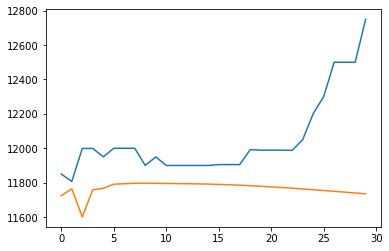

In [206]:
# plot the test data and predicitons
plt.plot(y_actual)
plt.plot(y_pred)
plt.show()

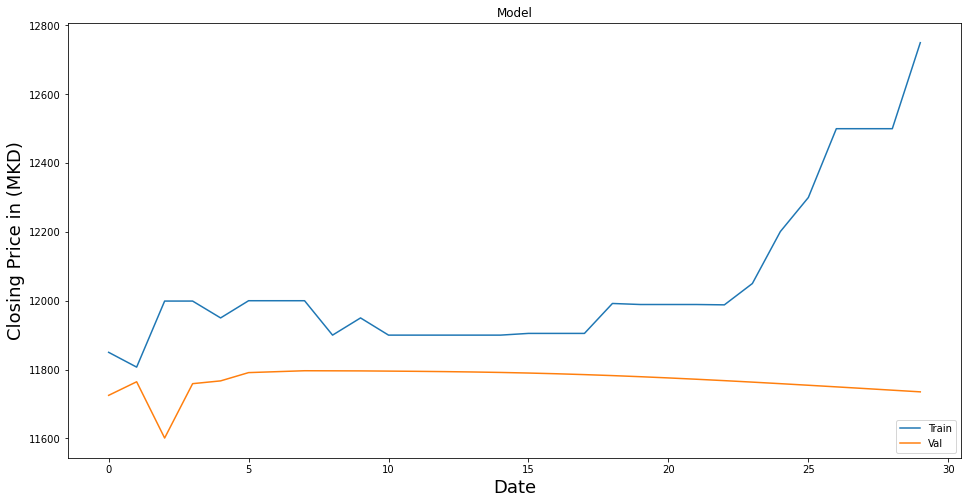

In [227]:
#plot the data
train_actual = scaler.inverse_transform(y_train.reshape(y_train.shape[0]*y_train.shape[1],1))
valid_actual = scaler.inverse_transform(y_valid.reshape(y_valid.shape[0]*y_valid.shape[1],1))
test_actual = scaler.inverse_transform(y_test.reshape(y_test.shape[0]*y_test.shape[1],1))
#valid['Predictions'] = predictions
#Visualize the Plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price in (MKD)', fontsize=18)
#plt.plot(train)
#plt.plot(train_actual)
#plt.plot(y_train_pred)
plt.plot(test_actual)
plt.plot(y_pred)
plt.legend(['Train','Val'], loc= 'lower right')
plt.show()